# Introduction: Understanding a model

In [10]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math
import pandas as pd

To understand the different facets of an explanatory model, let's consider a simple one: A mathematical model of response times for motor movements, known as Fitts' Law. Fitts' Law is an equation that predicts the time required to move a hand (or a cursor, or a pen) to a target area that has width $W$ and is located at a distance $D$ from the current position of the hand. Figure illustrates a typical example: calculating the time needed to move a cursor from one position to a different area. According to Fitts' Law, the time $T$ is related to width $W$ and distance $D$ by Equation : 

\begin{equation}
    T = a + b \log_2 \left( \frac{2D}{W} \right)
\end{equation}

In [11]:
# Fitts' law
def fitts(d, w, a=0.81, b= 1.12):
    """Fitts' law"""
    return a + b * (math.log2( 2 * d / w))

where $a$ is an intercept, and can be consider the minimum amount of time required to initiate any movement, while $b$ is a scaling factor, and can considered as a general parameter that captures an individual's speed of movement.

## Inside a Model: Fit, Features, and Free Parameters

If we peek inside a model (_any_ model) we can find some common elements. First, any model must have an _output_. In the case of Fitt's law, the output is the movement time $T$. This output might or might not reflect the data; the degree to which the model's output matches the data is called the model's _fit_. 

Second, each model contains certain quantities that capture specific aspects of the outside world and environment. In the equation, for example, the quantities $W$ and $D$ (width and distance of the target) represent everything we need to know about the world in which we need to make a movement. These variables are called _features_; in choosing the appropriate features, the designer of a model implicitly defines the levels of abstraction and the degree of simplification they want to impose on the world. Note that, once the level of abstraction is chosen, the features are, in principle, measurable properties of the outside world. (A partial exception to this rule is represented by contemporary deep-learning models, which are trained on raw data and are capable at extracting features on their own), 

Finally, the equation contains two more variables, $a$ and $b$. Unlike $D$ and $W$, they do not represent a measurable property of the world; in fact, there is no way they can be measured independently of the the equation itself. These variables, which mediate the effect of the features (the outside world) on the output, are called _free parameters_. One of the defining characteristics of explanatory models is that, because they embody a theory, it is somewhat clear what their parameters represent. By looking at the equation, it is clear that no response time time can ever be smaller than $a$; thus, $a$ can be thought of as the smallest time it takes to initiate a movement on the given device. The paramenter $b$, on the other hand, mediates the additional time it takes to move a cursor to a given location.  Thus, we can think of $b$ as representing the _effort_ necessary to control the movement itself. In general, a movement will be slower as $D$ grows and faster as $W$ grows, but some individuals will be faster overall, while others will need more time to move the cursor; these differences will be reflected in different values of $b$, and we can say that, when $b$ is smaller, the amount of effort that the movement takes is also smaller.

## Fitting a Model

But, now that we have identified features and free parameters, how do we know whether our model is any good?

To do so, we need to find the specific parameters the model that better fit the data. In the case of Fitts' model, that comes down to finding that data values of $a$ and $b$ that reduce the difference between the model's prediction $Y'$ and the actual data $Y$. This difference, or any other difference we want to minimize, is called the _loss function_.

Suppose, for instance, you ran an experiment varying the distance $D$ from  a cursor to a target are of width $W$, and you obtain the data below

In [12]:
## Example data

data = {"W" : [100, 150, 220, 110, 40],
        "D" : [300, 50, 100, 200, 250],
       "time" : [3.36, 1.08, 1.16, 3.07, 4.12]}

df = pd.DataFrame(data)

df

,W,D,time
0,100,300,3.36
1,150,50,1.08
2,220,100,1.16
3,110,200,3.07
4,40,250,4.12


We can define a loss function that quantifies how close the predictions of the Fitts model come to the times recorded in the third column in the table. For each combination of values of the parameters $a$ and $b$, we can plug in the different values of $W$ and $D$ and compare the model's predictions $Y'$ against the five observed values $Y$. A convenient way to do so is to calculate the sum of squares, much as it is done in statistics:

\begin{equation*}
    L = \sum_{y \in Y} (y-y')^2
\end{equation*}

Fitting a model is, therefore, the process of finding the values of parameters $a$ and $b$ that minimize the output of this equation.

In [13]:
# Loss
    
def loss(a, b):
    """Loss function"""
    Ypred = [fitts(x[0], x[1], a=a, b=b) for x in zip(df.D, df.W)]
    Yobs = df.time
    return np.sum((Ypred - Yobs)**2)

### Direct Calculation (thorugh Linear Regression)

In some cases, you might be lucky enough that there are some specific formulae that let you calculate the ideal parameters in a few simple steps. This is the case of linear regression. It also happens to be the case of Fitt's law. If you consider Fitts' equation, you'll notice that the it is essentially a linear equation of the form $y = a + bx$, once you take $\log_2(2D/W)$ as your independent variable $x$. To find the two values of $a$ and $b$ that create the better fit, you simply combine all of the pairs of $W$ and $D$ into a single variable $x$, concatenate all of these variables into a vector $X$, and apply the linear regression formula: $(X^TX)^{-1} X^T Y$.

In [14]:
# Create a new feature that combines W and D

x = np.log2(2 * df.D / df.W)

# Matrix algebra

X = np.array(x)
ones = np.ones((5, 1))

X.resize(5, 1)
X = np.dstack((ones, X)).squeeze()

Y = np.array(df.time)
Y.resize(5,1)

The result, in this case, is $a = 1.4438$ and $b= 0.7560$. 

In [15]:
a_star, b_star = la.inv(X.T.dot(X)).dot(X.T).dot(Y)
print("a = %.4f, b= %.4f" % (a_star, b_star))

a = 1.4438, b= 0.7560


With these parameters value, the loss function measures only 0.093. Notice that, to calculate these values, we had to change the model's {\em features}: Fitts' model sees the world as made of distances and widths, but the linear regression model sees only a single value $x$. This is another case in which you need to transform the data to fit it into the model's worldview. 

In [17]:
loss(float(a_star), float(b_star))

0.09370449541006619

But is this a good value? You can judge for yourself: This figure shows the predictions of Fitts' Law, represented as line, against the experimental results. 

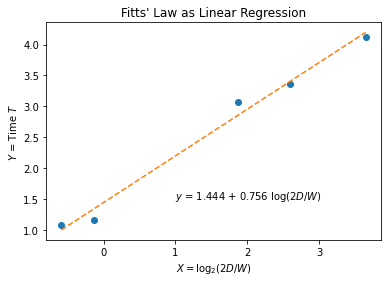

In [21]:
plt.plot(x, Y, "o")
xx = np.linspace(min(x), max(x))
yy = a_star + b_star*xx
plt.plot(xx, yy, "--")
plt.xlabel("$X = \log_2(2D/W$)")
plt.ylabel("$Y$ = Time $T$")
plt.title("Fitts' Law as Linear Regression")
plt.text(x=1, y=1.5, s="$y$ = %.3f + %.3f $\log (2D/W)$" % (a_star, b_star))
plt.savefig("fitts_linear.png")
plt.show()

### Grid Search

But what if we cannot use a direct formula to calculate the best values of a model's parameters? In the most general case, it is possible to use brute force and examine multiple values of $a$ and $b$ until we identify the combination that minimizes our loss function. For example, one could sample all values of $a$ and $b$ from 0.5 to 1.5 in increments of 0.01, and compute the loss function for each combination. This approach, called {\em grid search}, gives you an approximate idea of fit of Fitts' model within a slide of its parameter space, as shown in the Figure. In the figure, colors represent the magnitude of the loss function, and darker areas represents smaller loss value and, thus, better fits. The cross sign "+" marks the position, in the parameter space, that corresponds to the solution found by linear regression. 

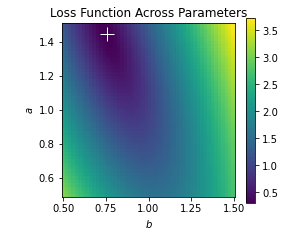

In [43]:
A = np.linspace(0.5, 1.5)
B = np.linspace(0.5, 1.5)
grid = np.zeros((A.size, B.size))

for i, a in enumerate(A):
    for j, b in enumerate(B):
        grid[i,j] = loss(a, b)
        

fig = plt.figure(figsize=(5, 3.2))

ax = fig.add_subplot(111)
ax.set_title('Loss Function Across Parameters')
X,Y = np.meshgrid(A, B)
plt.pcolormesh(A, B, np.sqrt(grid), shading="auto")
plt.plot(b_star, a_star, "+", color="white", markersize=14)
ax.set_aspect('equal')
ax.set_xlabel("$b$")
ax.set_ylabel("$a$")

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.savefig("fitts_grid.png")
plt.show()

However, this brute force, grid-search approach is rarely used in practice, as sampling all of the parameters is often unfeasible--especially as models become more complex and take longer to run. For example the plot in Figure \ref{fig:intro:fitts_grid} was generated by examining 10,000 combination of $a$ and $b$ values; such as a sample might not be feasibile. Furthermore, grid search requires setting a predefined sampling that discretaizes the possible values of $a$ and $b$. For example, the grid search examined cases in which $a=1.44$ and $a=1.45$, but never examined the case in which $a = 1.4438$; such a value would, in fact, be invisible to the method. For all of these reason, it is common to use special techniques called _optimization algorithms_ instead of grid searches. 

### Optimization

Optimization algorithms capitalize on the fact that, in most models, similar parameter values would produce similar results in terms of the model's loss function. In Fitt's law, for example, changing the value of $a$ from 1.44 to 1.45 does not produce appreciable changes in the loss function, no matter what the value of $b$ is. Furthermore, the direction of the changes in the loss function is usually consistent: If changing $a$ from 1.44 to 1.45 increases the loss function, then a further change of $a$ to 1.46 would likely result in an even larger loss value. In other words, that the surface of the loss function over the two parameters' values is smooth.  And smooth functions can be explored fairly easily by examining finding out the direction in which the parameters can be changed to reduce the loss function.  This is exactly what optimization algorithms do:they start with an initial guess for the model parameters, and modify them iteratively in the direction that reduces the loss function, until a minimum value is found\footnote{For this reason, these algorithms are also called _minimization_ algorithms.}. Optimization algorithms explore only a small portion of the parameter space, but they quickly converge over the correct solution. The Figure below depicts the points (in white) explored by one such method, the Nelder-Mead algorithm, to find the values of $a$ and $b$ that minimize the loss function of Fitts' Law, starting at $a=1$, $b=1$ and terminating at the same values that were identified by linear regression. 

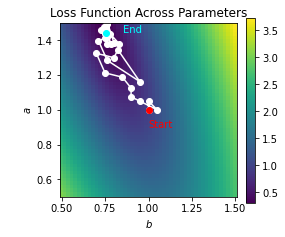

In [40]:
global path 
path = []
def vloss(vec):
    """Vector form of loss function"""
    global path
    path += [vec]
    return loss(vec[0], vec[1])

opt.minimize(vloss, np.array([1, 1]), method="Nelder-Mead")

fig = plt.figure(figsize=(5, 3.2))

ax = fig.add_subplot(111)
ax.set_title('Loss Function Across Parameters')
plt.pcolormesh(A, B, np.sqrt(grid), shading="auto")
plt.plot([x[1] for x in path], [x[0] for x in path], "-o", color="white")
start = path[0]
end = path[-1]
plt.plot(start[1], start[0], marker="o", color="red")
plt.text(start[1], start[0] - 0.1, s="Start", color="red")

plt.plot(end[1], end[0], marker="o", color="cyan")
plt.text(end[1] + 0.1, end[0], s="End", color="cyan")


ax.set_aspect('equal')
ax.set_xlabel("$b$")
ax.set_ylabel("$a$")
ax.set_ylim(0.5, 1.5)

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.savefig("fitts_optimize.png")
plt.show()